<a href="https://colab.research.google.com/github/AgataPolejowska/AI-CF/blob/main/Roboflow_Compare_EfficnetDet_YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

YoloV3 has been the go to model for image detection use cases in application development because of its small size, quick inference time, and portability. Recently, the Google Brain team has released EfficientDet, which has shown promise to perform better under more stringent computational constraints than YoloV3 on COCO (a general image detection task). 

In this notebook, we put the claims of EfficientDet to the test. We compare the **model size, training time, downstream performance, and inference time** of YoloV3 and EfficientDet-D0 on a custom dataset from Roboflow. To run on your own custom dataset, you only need to change one line of code that you will recieve after uploading your data set to Roboflow!


#### ![Post image](https://i.imgur.com/eisthE4.png)

Image Citation: http://clipart-library.com/ 



### **Data Download** 

We will download our data in two formats from Roboflow. COCO json for EfficientDet and Yolov3 Darknet text. Our data contains examples of labeling chess pieces, which we at Roboflow consider our "hello world" for image detection. 

### **Model training** 

To familiarize with training EfficientDet with Roboflow [see this blog post](incoming). 
To familiarize with training YoloV3 with Roboflow [see this blog post](https://blog.roboflow.ai/training-a-yolov3-object-detection-model-with-a-custom-dataset/)

Both of our implementations of the two models are in pytorch. 

### **Measuring training time** 

In order to measure training time, we train each model to the point of convergence. 

### **Measuring model size**

We look at how much storage is required to host the trained model weights for each implementation

### **Measuring downstream performance**

We evaluate the mAP (mean Average Precision) on our test set split. 

### **Measuring Inference Time** 

We time the average amount of time it takes the model to make inferences on a single shot image detection task. 

### **Conclusion**

What did we find

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)



# Set Up Environment

In [ ]:
#look at specs
!df -h


Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   32G   34G  49% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   16K  6.4G   1% /var/colab
/dev/sda1        75G   33G   43G  44% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

In [ ]:
!cat /proc/meminfo

MemTotal:       13333556 kB
MemFree:        10538116 kB
MemAvailable:   12461524 kB
Buffers:           74320 kB
Cached:          2006724 kB
SwapCached:            0 kB
Active:           728140 kB
Inactive:        1785584 kB
Active(anon):     412256 kB
Inactive(anon):      336 kB
Active(file):     315884 kB
Inactive(file):  1785248 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               924 kB
Writeback:             0 kB
AnonPages:        432764 kB
Mapped:           221928 kB
Shmem:               940 kB
Slab:             166124 kB
SReclaimable:     126340 kB
SUnreclaim:        39784 kB
KernelStack:        3488 kB
PageTables:         5356 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666776 kB
Committed_AS:    2507124 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              920 kB
AnonHugePages:   

In [ ]:
#first set up for EfficientDet
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX


#second set up for YOLOv3
import os
import torch
from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
!git clone https://github.com/roboflow-ai/yolov3  # clone


Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 3744 (delta 24), reused 30 (delta 12), pack-reused 3702
Receiving objects: 100% (3744/3744), 132.19 MiB | 31.29 MiB/s, done.
Resolving deltas: 100% (797/797), done.
Checking out files: 100% (4032/4032), done.
     |████████████████████████████████| 540.1MB 32kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-cp36-none-any.whl size=17452 sha256=34d7d74b41b2f0a8fa80acc8b8412c86dec94b9e9f0728ad3aa5a68bdbd9cad9
  Stored in directory: /root/.cache/pip/wheels/62/4f/a3/afd4a68f5add45a668c14efa53b64d5cffb2be6bacf993c151
Successfully built dicttoxml
     - 378kB 6.4MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=ad41b03ba33f3b33353

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=346db5a16d87ae5db02dcf2571cdf769a1db7d424a53e6e5372cc3c1eff947a6
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch
     |████████████████████████████████| 204kB 2.8MB/s 
PyTorch 1.4.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
Cloning into 'yolov3'...
remote: Enumerating objects: 8443, done.
remote: Total 8443 (delta 0), reused 0 (delta 0), pack-reused 8443
Receiving objects: 100% (8443/8443), 6.90 MiB | 22.57 MiB/s, done.
Resolving deltas: 100% (5819/5819), done.


# Retrieve Data and Set Up Data Directories

In [ ]:
#input your COCO json link here 
!mkdir ed_data
%cd ed_data
!curl -L [YOUR LINK HERE] > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/ed_data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1016      0 --:--:-- --:--:-- --:--:--  1014
100 6374k  100 6374k    0     0  4933k      0  0:00:01  0:00:01 --:--:--  287M
Archive:  roboflow.zip
 extracting: train/BloodImage_00240_jpg.rf.02e03d6cdaa6a0c4446fbede5b024dd2.jpg  
 extracting: train/BloodImage_00196_jpg.rf.03390ec25911b1035cae7b7ea3b8245d.jpg  
 extracting: train/BloodImage_00053_jpg.rf.039e0e2cfc3db970127dbb3f4ae9ee6d.jpg  
 extracting: train/BloodImage_00256_jpg.rf.03ae10c8cb261253736684b6b1774dc4.jpg  
 extracting: train/BloodImage_00018_jpg.rf.02cc3c42d3b2af24c2432c9ec88bb492.jpg  
 extracting: test/BloodImage_00190_jpg.rf.03484116dcad7715c77d30654056fc54.jpg  
 extracting: valid/BloodImage_00377_jpg.rf.0312942b2d584915ce2498b70b4c7fd9.jpg  
 extracting: train/BloodImage_00320_jpg.rf.0162f52310ba3d29d7a1a9cd30a4

In [ ]:
#we'll download yolo data into content file directory
%cd ..
!curl -L [YOUR LINK HERE] > roboflow.zip; unzip roboflow.zip; rm roboflow.zip



/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   890  100   890    0     0   1326      0 --:--:-- --:--:-- --:--:--  1326
100 5072k  100 5072k    0     0  5289k      0 --:--:-- --:--:-- --:--:-- 5289k
Archive:  roboflow.zip
 extracting: train/BloodImage_00240_jpg.rf.02e03d6cdaa6a0c4446fbede5b024dd2.jpg  
 extracting: valid/BloodImage_00017_jpg.rf.03e73d66a140b6b0fb97b3170af9ff27.jpg  
 extracting: valid/BloodImage_00377_jpg.rf.0312942b2d584915ce2498b70b4c7fd9.jpg  
 extracting: train/BloodImage_00196_jpg.rf.03390ec25911b1035cae7b7ea3b8245d.jpg  
 extracting: train/BloodImage_00242_jpg.rf.007c73259d80a031ed7705cc0d1fa86c.jpg  
 extracting: train/BloodImage_00053_jpg.rf.039e0e2cfc3db970127dbb3f4ae9ee6d.jpg  
 extracting: test/BloodImage_00190_jpg.rf.03484116dcad7715c77d30654056fc54.jpg  
 extracting: train/BloodImage_00320_jpg.rf.0162f52310ba3d29d7a1a9cd30a43488.jpg

In [ ]:
#set up EfficientDet folder structure
!mkdir ed_data/Chess
!mkdir ed_data/Chess/annotations
!mkdir ed_data/Chess/Annotations
!mkdir ed_data/Chess/Images

%cp ed_data/train/_annotations.coco.json ed_data/Chess/annotations/instances_Images.json
%cp ed_data/train/*.jpg ed_data/Chess/Images/

In [ ]:
#set up yolo folder structure
%cd train
%mkdir labels
%mkdir images
%mv *.jpg ./images/
%mv *.txt ./labels/
%cd images
# create Ultralytics specific text file of training images
file = open("train_images_roboflow.txt", "w") 
for root, dirs, files in os.walk("."):
    for filename in files:
      # print("../train/images/" + filename)
      if filename == "train_images_roboflow.txt":
        pass
      else:
        file.write("../train/images/" + filename + "\n")
file.close()


%cd ../../valid
%mkdir labels
%mkdir images

%mv *.jpg ./images/
%mv *.txt ./labels/
%cd images


# create Ultralytics specific text file of validation images
file = open("valid_images_roboflow.txt", "w") 
for root, dirs, files in os.walk("."):
    for filename in files:
      # print("../train/images/" + filename)
      if filename == "valid_images_roboflow.txt":
        pass
      else:
        file.write("../valid/images/" + filename + "\n")
file.close()

%cd ../../yolov3/data
%cat ../../train/_darknet.labels > ../../train/roboflow_data.names

def get_num_classes(labels_file_path):
    classes = 0
    with open(labels_file_path, 'r') as f:
      for line in f:
        classes += 1
    return classes

# update the roboflow.data file with correct number of classes
import re

num_classes = get_num_classes("../../train/_darknet.labels")
with open("roboflow.data") as f:
    s = f.read()
with open("roboflow.data", 'w') as f:
    
    # Set number of classes num_classes.
    s = re.sub('classes=[0-9]+',
               'classes={}'.format(num_classes), s)
    f.write(s)

%cat roboflow.data

/content/train
/content/train/images
/content/valid
/content/valid/images
/content/yolov3/data
classes=3
train=../train/images/train_images_roboflow.txt
valid=../valid/images/valid_images_roboflow.txt
names=../train/roboflow_data.names


# Measuring Training Time

In [ ]:
%cd ../

/content/yolov3


In [ ]:
#training YOLOv3 model
#on Tesla P100-PCIE-16GB
#based on previous experiments on our validaiton set we think the model converges completely in 100 epochs
!python3 train.py --data data/roboflow.data --epochs 40
#total training time 24.5 min

# 0.458 hours. 27.5 min

Namespace(accumulate=4, adam=False, batch_size=16, bucket='', cache_images=False, cfg='cfg/yolov3-spp.cfg', data='data/roboflow.data', device='', epochs=40, evolve=False, img_size=[416], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=False, single_cls=False, var=None, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

2020-04-28 15:41:50.270286: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3090      0 --:--:-- --:--:-- --:--:--  3090
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     

In [ ]:
%cd /content/
#now train EfficientDet model

/content


In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");
from train_detector import Detector
gtf = Detector();

#directs the model towards file structure
root_dir = "./";
coco_dir = "ed_data/Chess";
img_dir = "./";
set_dir = "Images";



In [ ]:
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=True)
gtf.Model();

#ed_data/Chess/annotations/instances_Images.json

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [ ]:
%%time
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)
gtf.Train(num_epochs=40, model_output_dir="trained/");
#total training time 18.3 min
#25.2 min

Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this fu


CPU times: user 13min 16s, sys: 1min 13s, total: 14min 29s
Wall time: 15min 35s


# Measuring Model Size

In [ ]:
#size of yolov3 in our test
#number of parameters 65,252,682
!du --block-size=1MB yolov3/weights/last.pt

253	yolov3/weights/last.pt


In [ ]:
#size of EfficientDet-D0 in our test
#number of parameters 3,900,000 
!du --block-size=1MB trained/signatrix_efficientdet_coco.pth

17	trained/signatrix_efficientdet_coco.pth


In [ ]:
!du --block-size=1MB trained/signatrix_efficientdet_coco.onnx

18	trained/signatrix_efficientdet_coco.onnx


In [ ]:
#param multiplier 17x
#model size 15x 

# Measuring Inference Time

In [ ]:
##first inference with effficientDet
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");
from infer_detector import Infer
gtf = Infer();
#our trained model weights are in here in onxx format
gtf.Model(model_dir="trained/")
#extract class list from our annotations
import json
with open('ed_data/train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])


In [ ]:
!ls test

BloodImage_00038_jpg.rf.63da20f3f5538d0d2be8c4633c7034a1.jpg
BloodImage_00038_jpg.rf.63da20f3f5538d0d2be8c4633c7034a1.txt
BloodImage_00044_jpg.rf.b0e2369642c5a7fa434ed8defa79e2ba.jpg
BloodImage_00044_jpg.rf.b0e2369642c5a7fa434ed8defa79e2ba.txt
BloodImage_00062_jpg.rf.e965ee152eea462d82706a2709abfe00.jpg
BloodImage_00062_jpg.rf.e965ee152eea462d82706a2709abfe00.txt
BloodImage_00090_jpg.rf.4fd1da847d2857b6092003c41255ea4c.jpg
BloodImage_00090_jpg.rf.4fd1da847d2857b6092003c41255ea4c.txt
BloodImage_00099_jpg.rf.5b178d758af2a97d3df8e5f87b1f344a.jpg
BloodImage_00099_jpg.rf.5b178d758af2a97d3df8e5f87b1f344a.txt
BloodImage_00112_jpg.rf.f8d86689750221da637a054843c72822.jpg
BloodImage_00112_jpg.rf.f8d86689750221da637a054843c72822.txt
BloodImage_00113_jpg.rf.a6d6a75c0ebfc703ecff95e2938be34d.jpg
BloodImage_00113_jpg.rf.a6d6a75c0ebfc703ecff95e2938be34d.txt
BloodImage_00120_jpg.rf.6742a4da047e1226a181d2de2978ce6d.jpg
BloodImage_00120_jpg.rf.6742a4da047e1226a181d2de2978ce6d.txt
BloodImage_00133_jpg.rf.

In [ ]:
#44 ms 
img_path = "ed_data/test/BloodImage_00369_jpg.rf.99ae139e5530a25980b7acdd56a4317c.jpg";
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

Done. (0.069s)


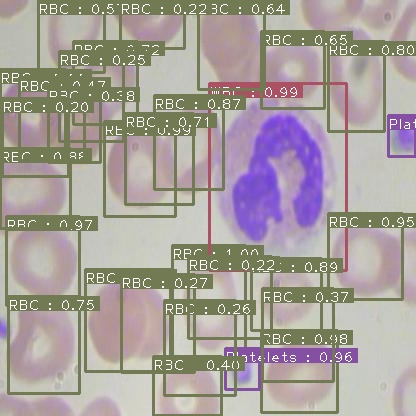

In [ ]:
#looks pretty good! 
from IPython.display import Image
Image(filename='output.jpg') 

In [ ]:
%cd yolov3/

/content/yolov3


In [ ]:
#now inference with YoloV3
#inference time is defined within detect.py 
#49 ms 
!python3 detect.py --weights weights/last.pt --source=../test/BloodImage_00369_jpg.rf.99ae139e5530a25980b7acdd56a4317c.jpg --names=../train/roboflow_data.names

Namespace(agnostic_nms=False, cfg='cfg/yolov3-spp.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=416, iou_thres=0.6, names='../train/roboflow_data.names', output='output', save_txt=False, source='../test/BloodImage_00369_jpg.rf.99ae139e5530a25980b7acdd56a4317c.jpg', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
image 1/1 ../test/BloodImage_00369_jpg.rf.99ae139e5530a25980b7acdd56a4317c.jpg: 416x416 3 Plateletss, 23 RBCs, 1 WBCs, Done. (0.033s)
Results saved to /content/yolov3/output
Done. (0.068s)


BloodImage_00369_jpg.rf.99ae139e5530a25980b7acdd56a4317c.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


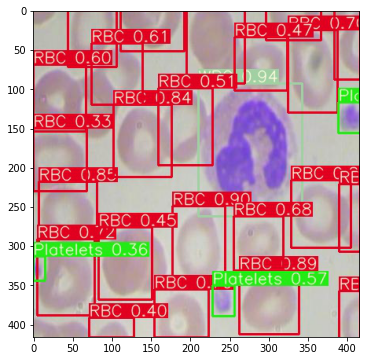

In [ ]:
# import libraries for display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
from glob import glob
import random
import PIL
# plot just one random image prediction
filename = random.choice(os.listdir('./output'))
print(filename)
Image('./output/' + filename)

# grab all images from our output directory
images = [ PIL.Image.open(f) for f in glob('./output/*') ]
# convert images to numPy
def img2array(im):
    if im.mode != 'RGB':
        im = im.convert(mode='RGB')
    return np.fromstring(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))

# create array of numPy images
np_images = [ img2array(im) for im in images ]

# plot ALL results in test directory (NOTE: adjust figsize as you please)
for img in np_images:
    plt.figure(figsize=(8, 6))
    plt.imshow(img)



In [ ]:
#measuring inference accross test set

for f in os.listdir('../test'):
  if f.endswith('.jpg'):
    !python3 detect.py --weights weights/last.pt --source=../test/{f} --names=../train/roboflow_data.names


Namespace(agnostic_nms=False, cfg='cfg/yolov3-spp.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=416, iou_thres=0.6, names='../train/roboflow_data.names', output='output', save_txt=False, source='../test/BloodImage_00266_jpg.rf.6d62684a33e2f5bc048803aba3177f58.jpg', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
image 1/1 ../test/BloodImage_00266_jpg.rf.6d62684a33e2f5bc048803aba3177f58.jpg: 416x416 1 Plateletss, 17 RBCs, 1 WBCs, Done. (0.028s)
Results saved to /content/yolov3/output
Done. (0.048s)
Namespace(agnostic_nms=False, cfg='cfg/yolov3-spp.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=416, iou_thres=0.6, names='../train/roboflow_data.names', output='output', save_txt=False, source='../test/BloodImage_00120_jpg.rf.6742a4da047e1226a181d2de2978ce6d.jp

In [ ]:
%cd .. 
for f in os.listdir('test'):
  if f.endswith('.jpg'):
    duration, scores, labels, boxes = gtf.Predict('test/'+f, class_list, vis_threshold=0.2);

/content
Done. (0.070s)
Done. (0.051s)
Done. (0.054s)
Done. (0.056s)
Done. (0.054s)
Done. (0.061s)
Done. (0.047s)
Done. (0.049s)
Done. (0.049s)
Done. (0.046s)
Done. (0.048s)
Done. (0.062s)
Done. (0.049s)
Done. (0.047s)
Done. (0.049s)
Done. (0.049s)
Done. (0.056s)
Done. (0.048s)
Done. (0.052s)
Done. (0.059s)
Done. (0.060s)
Done. (0.059s)
Done. (0.069s)
Done. (0.061s)
Done. (0.063s)
Done. (0.059s)
Done. (0.076s)
Done. (0.048s)
Done. (0.061s)
Done. (0.051s)
Done. (0.050s)
Done. (0.050s)
Done. (0.059s)
Done. (0.051s)
Done. (0.049s)
Done. (0.051s)


In [ ]:
#average inference time YOLOv3 39 ms
#average inference time efficientDet 37 ms

# Measuring Performance

In [ ]:
%cd /content/
!git clone https://github.com/Cartucho/mAP

/content
Cloning into 'mAP'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 902 (delta 9), reused 15 (delta 4), pack-reused 880
Receiving objects: 100% (902/902), 14.72 MiB | 27.76 MiB/s, done.
Resolving deltas: 100% (313/313), done.


In [ ]:
%cp test/_darknet.labels mAP/scripts/extra/class_list.txt
%cp test/_darknet.labels mAP/input/


In [ ]:
%rm -rf mAP/input/ground-truth/
%mkdir mAP/input/ground-truth/

In [ ]:
%mkdir mAP/input/images

In [ ]:
%mkdir mAP/input/images-optional/

mkdir: cannot create directory ‘mAP/input/images-optional/’: File exists


In [ ]:
%cp test/*txt mAP/input/ground-truth/

In [ ]:
%cp test/*jpg mAP/input/images-optional/

In [ ]:
%cp test/*jpg mAP/input/images/

In [ ]:
#%ls test
%cp test/*jpg mAP/input/images-optional/

In [ ]:
%cd mAP/scripts/extra/

/content/mAP/scripts/extra


In [ ]:
!python convert_gt_yolo.py

Conversion completed!


In [ ]:
%cd /content/mAP

/content/mAP


In [ ]:
%cat input/ground-truth/1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.a07af6147d4a79376c182d2d95c639ec.txt


cat: input/ground-truth/1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.a07af6147d4a79376c182d2d95c639ec.txt: No such file or directory


In [ ]:
%cd /content

/content


In [ ]:
%rm -rf mAP/input/detection-results/
%mkdir mAP/input/detection-results/

In [ ]:
for f in os.listdir('test'):
  if f.endswith('.jpg'):
    duration, scores, labels, boxes = gtf.Predict('test/'+f, class_list, vis_threshold=0.2);
    scores = scores.tolist()
    boxes = boxes.tolist()
    labels = labels.tolist()
    with open('mAP/input/detection-results/' + f[:-4] + '.txt', 'w') as out_file:
      #write detection result
      for i in range(len(scores)):
        #print(scores)
        line = class_list[labels[i]] + ' ' + str(scores[i]) + ' ' + str(' '.join([str(j) for j in boxes[i]]))
        out_file.write(line)
        if i < len(scores) - 1:
          out_file.write('\n')



Done. (0.064s)
Done. (0.049s)
Done. (0.051s)
Done. (0.059s)
Done. (0.048s)
Done. (0.048s)
Done. (0.050s)
Done. (0.048s)
Done. (0.047s)
Done. (0.048s)
Done. (0.046s)
Done. (0.047s)
Done. (0.055s)
Done. (0.049s)
Done. (0.051s)
Done. (0.060s)
Done. (0.049s)
Done. (0.050s)
Done. (0.052s)
Done. (0.048s)
Done. (0.049s)
Done. (0.048s)
Done. (0.065s)
Done. (0.065s)
Done. (0.047s)
Done. (0.049s)
Done. (0.050s)
Done. (0.048s)
Done. (0.050s)
Done. (0.062s)
Done. (0.051s)
Done. (0.051s)
Done. (0.059s)
Done. (0.057s)
Done. (0.050s)
Done. (0.065s)


In [ ]:
%cd mAP/

/content/mAP


In [ ]:
#evaluation results for EfficientDet
!python main.py -na

78.59% = Platelets AP 
77.87% = RBC AP 
96.47% = WBC AP 
mAP = 84.31%
<Figure size 640x480 with 1 Axes>


In [ ]:

%cd ..

/content


In [ ]:
%cd yolov3/

/content/yolov3


In [ ]:
!python3 detect.py --weights weights/last.pt --source=../test/ --names=../train/roboflow_data.names --save-txt

Namespace(agnostic_nms=False, cfg='cfg/yolov3-spp.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=416, iou_thres=0.6, names='../train/roboflow_data.names', output='output', save_txt=True, source='../test/', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
image 1/36 ../test/BloodImage_00038_jpg.rf.63da20f3f5538d0d2be8c4633c7034a1.jpg: 416x416 1 Plateletss, 21 RBCs, 1 WBCs, Done. (0.027s)
image 2/36 ../test/BloodImage_00044_jpg.rf.b0e2369642c5a7fa434ed8defa79e2ba.jpg: 416x416 3 Plateletss, 17 RBCs, 2 WBCs, Done. (0.018s)
image 3/36 ../test/BloodImage_00062_jpg.rf.e965ee152eea462d82706a2709abfe00.jpg: 416x416 3 Plateletss, 18 RBCs, 1 WBCs, Done. (0.021s)
image 4/36 ../test/BloodImage_00090_jpg.rf.4fd1da847d2857b6092003c41255ea4c.jpg: 416x416 3 Plateletss, 17 RBCs, 1 WBCs, Done. (0.020s)
image 5/3

In [ ]:
#reorder and write to mAP calc
%cd ..
%rm -rf mAP/input/detection-results/
%mkdir mAP/input/detection-results/

for f in os.listdir('yolov3/output/'):
  if f.endswith('txt'):
    with open('mAP/input/detection-results/' + f[:-8] + '.txt', 'w') as out_file:
      with open('yolov3/output/' + f) as read_file:
        lines = read_file.readlines()
        for line in lines:
          line = line.split()
          out_file.write(class_list[int(line[4]) + 1] + ' ' + line[5] + ' ' + ' '.join(line[0:4]))
          out_file.write('\n')



/content


In [ ]:
%cd mAP
#!python scripts/extra/intersect-gt-and-dr.py
!python main.py -na

/content/mAP
72.15% = Platelets AP 
74.41% = RBC AP 
95.54% = WBC AP 
mAP = 80.70%
<Figure size 640x480 with 1 Axes>
